In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from collections import namedtuple


### Task 1 — Check BIBO Stability From Transfer Function Poles

#### <strong>Concept used : </strong>

| Pole location | Multiplicity | Behavior                   |
| ------------- | ------------ | -------------------------- |
| Re(p) < 0     | any          | Stable                     |
| Re(p) = 0     | 1            | Marginal (not BIBO stable) |
| Re(p) = 0     | ≥ 2          | **Unstable**               |
| Re(p) > 0     | any          | **Unstable**               |


In [2]:
def parse_pole(x):
    """ Convert various input types to complex. Raise value error if invalid or on bad input.
    """
    
    if isinstance(x,complex):
        return x
    if isinstance(x,(int,float,np.integer,np.floating)):
        return complex(x)
    if isinstance(x,str):
        # allow strings like '3+4j' or '5-2j'
        try:
            return complex(x.replace(' ',''))
        except Exception as e:
            raise ValueError(f"Cannot convert string '{x}' to complex number: {e}")
    raise ValueError(f"Unsupported type {type(x)} for pole conversion.")

def group_poles(poles, tol= 1e-8):
    """ Group poles into real and complex conjugate pairs.
    
    Args:
        poles: list of poles (can be int, float, complex, or str)
        tol: tolerance for considering imaginary parts as zero
    Returns:
        namedtuple with 'real' and 'complex_pairs' attributes
    """
    poles = [parse_pole(p) for p in poles]
    used = [False]*len(poles)
    groups = []
    for i, p in enumerate(poles):
        if used[i]:
            continue
        count = 1
        for j in range(i+1, len(poles)):
            if not used[j] and np.isclose(p,poles[j],atol = tol, rtol = 0):
                count += 1
                used[j] = True
        groups.append((p,count))
    return groups

def classify_poles(poles , tol = 1e-8):
    """
    Classify system BIBO stability from poles.
    Returns (classification, details_dict)
    classification in {"Stable", "Marginally stable", "Unstable"}
    """   
    
    groups = group_poles(poles, tol= tol)
    reasons = []
    
    # Check for right-half plane
    for p,m in groups:
        if p.real> tol:
            reasons.append(f"Poles at {p} has Re>0 -> right-half plane(RHP).")
            return "Unstable", {"groups": groups, "reasons": reasons}
    
    # Check jw-axis (Re ~ 0)
    axis_grops = [(p,m) for p, m in groups if abs(p.real)<= tol]
    
    # if any axis pole with multiplicity>=2 -> unstable
    for p,m in axis_grops:
        if m >= 2:
            reasons.append(f"Pole at {p} on Re = 0 (jw-axis) with multiplicity {m} -> Unstable.")
            return "Unstable", {"groups": groups, "reasons": reasons}
        
    # if any axis pole (single) and no RHP poles -> marginally stable
    if len(axis_grops) > 0:
        reasons.append(f"Pole(s) on jw-axis (Re=0) but all have multiplicity 1 -> Marginally stable.")
        return "Marginally stable", {"groups": groups, "reasons": reasons}
    # Otherwise all Re < 0 -> Stable
    reasons.append("All poles have Re < 0 -> Stable.")
    return "Stable", {"groups": groups, "reasons": reasons}


def report_classification(poles, tol=1e-8):
    cls, details = classify_poles(poles, tol=tol)
    groups = details["groups"]
    reasons = details["reasons"]
    print("Input poles:")
    print(" ", poles)
    print("\nGrouped poles (representative, multiplicity):")
    for p,m in groups:
        # show nicely with limited decimals
        rep = complex(np.round(p.real, 10) + 1j*np.round(p.imag, 10))
        print(f"  {rep}  , multiplicity = {m}")
    print("\nConclusion:")
    print(" ", cls)
    print("\nReasoning:")
    for r in reasons:
        print(" -", r)
    return cls, details

# ---- Example runs from the prompt ----
examples = [
    ([-2, -1+1j, -1-1j], "Stable (example)"),
    ([0, -2], "Marginal (example)"),
    ([0, 0], "Unstable (double jw-axis pole)"),
]

for poles, note in examples:
    print("========================================")
    print(note)
    report_classification(poles)
    print("========================================\n")

# ---- Additional demonstrations ----
extra = [
    (["-0.00000000001+0j", -1], "Tiny numerical positive? treated as Re<tol (stable)"),
    (["0.0j", "0+1e-10j"], "Two poles extremely close to jw-axis; multiplicity check depends on tol"),
    ([1+0j, -1], "One RHP pole -> Unstable"),
    (["-1+0j", "-1+0j", "-1+0j"], "Triple pole in LHP -> Still Stable"),
]

for poles, note in extra:
    print("---- extra:", note)
    report_classification(poles)
    print()

    

Stable (example)
Input poles:
  [-2, (-1+1j), (-1-1j)]

Grouped poles (representative, multiplicity):
  (-2+0j)  , multiplicity = 1
  (-1+1j)  , multiplicity = 1
  (-1-1j)  , multiplicity = 1

Conclusion:
  Stable

Reasoning:
 - All poles have Re < 0 -> Stable.

Marginal (example)
Input poles:
  [0, -2]

Grouped poles (representative, multiplicity):
  0j  , multiplicity = 1
  (-2+0j)  , multiplicity = 1

Conclusion:
  Marginally stable

Reasoning:
 - Pole(s) on jw-axis (Re=0) but all have multiplicity 1 -> Marginally stable.

Unstable (double jw-axis pole)
Input poles:
  [0, 0]

Grouped poles (representative, multiplicity):
  0j  , multiplicity = 2

Conclusion:
  Unstable

Reasoning:
 - Pole at 0j on Re = 0 (jw-axis) with multiplicity 2 -> Unstable.

---- extra: Tiny numerical positive? treated as Re<tol (stable)
Input poles:
  ['-0.00000000001+0j', -1]

Grouped poles (representative, multiplicity):
  0j  , multiplicity = 1
  (-1+0j)  , multiplicity = 1

Conclusion:
  Marginally stable

### Concept:

For a continuous-time LTI system, a pole at 𝑝 ,p with multiplicity 𝑘
k contributes a term in the impulse response of the form :

         h(p,k)= (t^(k-1) exp(pt))/ (k-1)!  , for all t>=0

p=-1, k=1 (stable simple pole) -> Stable (all Re(p) < 0)


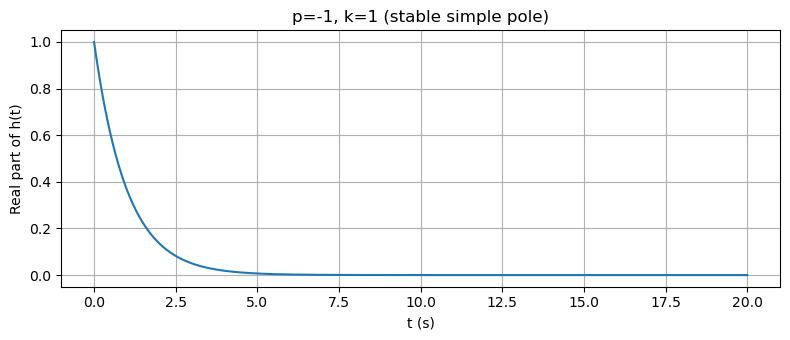

p=-1, k=3 (stable repeated pole) -> Stable (all Re(p) < 0)


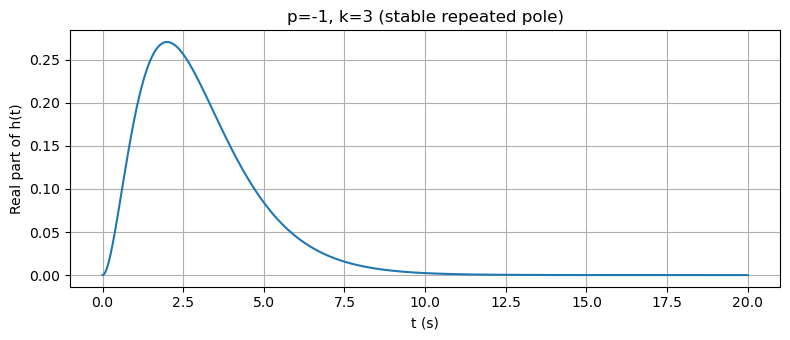

p=0j, k=1 (marginal, sinusoid-like) -> Marginal (poles on imag axis, multiplicity 1) — not BIBO stable


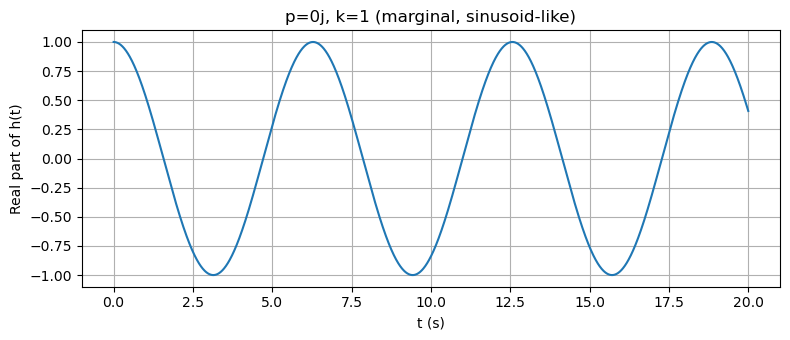

p=0j, k=2 (imag axis repeated -> grows) -> Unstable: pole on imaginary axis with multiplicity >= 2


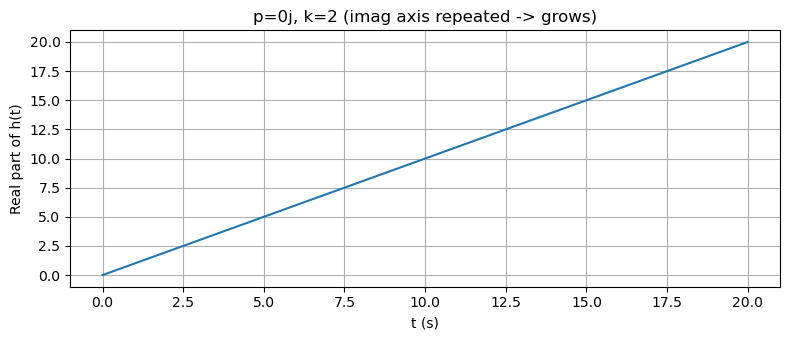

p=-0.1+2j, conjugate pair (oscillatory decay) -> Stable (all Re(p) < 0)


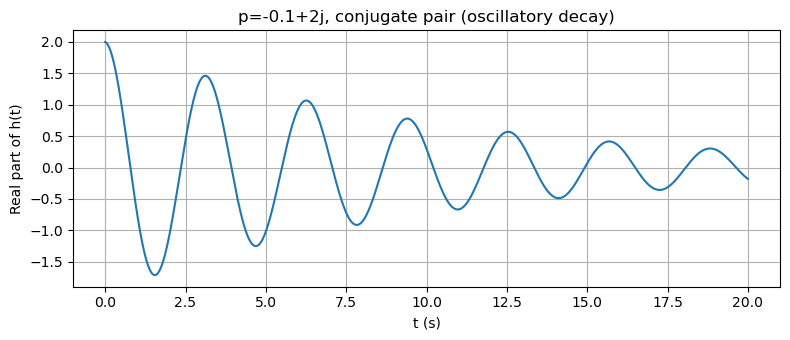

In [3]:
# Continuous-time pole multiplicity inspector + impulse-response plotter
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
from collections import defaultdict

# ---- Utilities ----
def group_poles(poles, tol=1e-8):
    """
    Group nearly-equal poles and return dict {representative: multiplicity}.
    poles : iterable of complex numbers
    """
    poles = list(poles)
    used = [False]*len(poles)
    groups = {}
    for i, p in enumerate(poles):
        if used[i]:
            continue
        mult = 1
        used[i] = True
        for j in range(i+1, len(poles)):
            if used[j]:
                continue
            if abs(p - poles[j]) < tol:
                mult += 1
                used[j] = True
        groups[p] = mult
    return groups

def stability_from_poles_continuous(poles, tol=1e-12):
    """Return short verdict string"""
    groups = group_poles(poles, tol=1e-8)
    # any RHP pole
    if any(np.real(p) > tol for p in poles):
        return "Unstable: pole with Re(p)>0"
    # poles on imaginary axis?
    imag_axis = [(p,m) for p,m in groups.items() if abs(np.real(p)) <= tol]
    for p,m in imag_axis:
        if m >= 2:
            return "Unstable: pole on imaginary axis with multiplicity >= 2"
    if len(imag_axis) > 0:
        return "Marginal (poles on imag axis, multiplicity 1) — not BIBO stable"
    return "Stable (all Re(p) < 0)"

# ---- Impulse response for single (p,k) term ----
def impulse_response_term(p, k, t):
    """Return h(t) = t^(k-1) * exp(p t) / (k-1)! evaluated for array t."""
    return (t**(k-1)) * np.exp(p * t) / factorial(k-1)

# ---- Full response from list of poles (summing individual terms) ----
def impulse_response_from_poles(poles, t, tol=1e-8):
    """
    Sum contributions from each pole grouping.
    Note: coefficients = 1/(k-1)! as used in the example; for general TF you'd need residues.
    """
    groups = group_poles(poles, tol=tol)
    h = np.zeros_like(t, dtype=complex)
    for p, k in groups.items():
        h += impulse_response_term(p, k, t)
    return h

# ---- Plot helper ----
def plot_impulse_response(t, h, title="Impulse response", real_only=True):
    plt.figure(figsize=(8,3.5))
    if real_only:
        plt.plot(t, np.real(h))
        plt.ylabel("Real part of h(t)")
    else:
        plt.plot(t, np.real(h), label='Real')
        plt.plot(t, np.imag(h), label='Imag')
        plt.legend()
    plt.title(title)
    plt.xlabel("t (s)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---- Example usage ----
if __name__ == "__main__":
    t = np.linspace(0, 20, 2001)   # choose time window & resolution
    examples = {
        "p=-1, k=1 (stable simple pole)": [ -1.0 ],
        "p=-1, k=3 (stable repeated pole)": [ -1.0, -1.0, -1.0 ],
        "p=0j, k=1 (marginal, sinusoid-like)": [ 1j ],
        "p=0j, k=2 (imag axis repeated -> grows)": [ 0j, 0j ],
        "p=-0.1+2j, conjugate pair (oscillatory decay)": [ -0.1+2j, -0.1-2j ],
    }

    for title, poles in examples.items():
        print(title, "->", stability_from_poles_continuous(poles))
        h = impulse_response_from_poles(poles, t)
        plot_impulse_response(t, h, title=title)


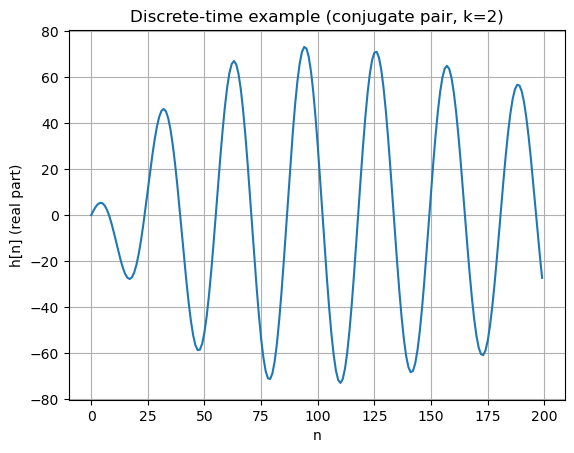

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def discrete_impulse_term(z, k, n):
    # returns n^(k-1) * z^n (no factorial)
    return (n**(k-1)) * (z**n)

n = np.arange(0,200)   # integer time
z = 0.99 * np.exp(1j*0.2)   # example pole inside unit circle
h = discrete_impulse_term(z, 2, n) + discrete_impulse_term(np.conj(z), 2, n)
plt.plot(n, np.real(h))
plt.xlabel("n")
plt.ylabel("h[n] (real part)")
plt.title("Discrete-time example (conjugate pair, k=2)")
plt.grid(True)
plt.show()


* Finding h(t) from given transfer/plant fucntion, plot and stability


Problem 1: H1(s) = 1 / (s^2 + 3s + 2)  -> poles at -1 and -2 (stable)
  Symbolic inverse Laplace h(t):
⎛ t    ⎞  -2⋅t
⎝ℯ  - 1⎠⋅ℯ    


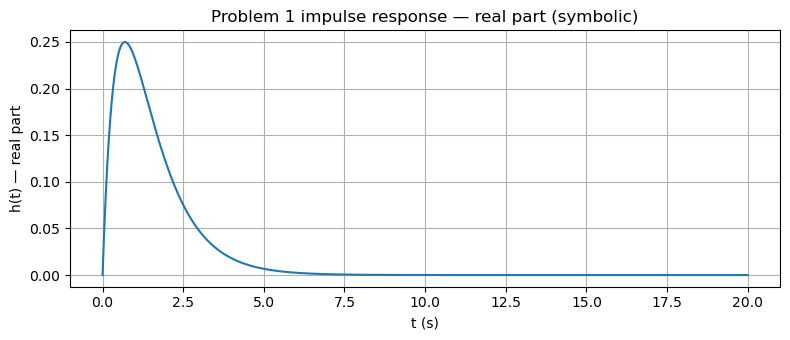

  Poles and multiplicities:
    -2    multiplicity = 1
    -1    multiplicity = 1
  Stability verdict: Stable (all Re<0)

Problem 2: H2(s) = 1 / (s^4 + 0*s^3 + 8*s^2 + 0*s + 16)  = 1/(s^2+4)^2  -> poles ±2j, multiplicity 2 (unstable)
  Symbolic inverse Laplace h(t):
  t⋅cos(2⋅t)   sin(2⋅t)
- ────────── + ────────
      8           16   


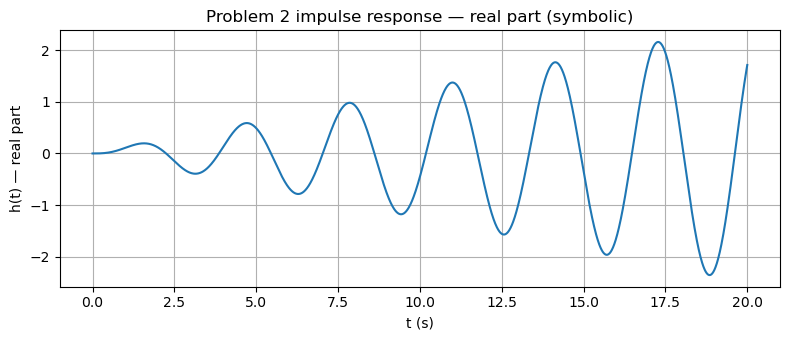

  Poles and multiplicities:
    0+-2j    multiplicity = 2
    0+2j    multiplicity = 2
  Stability verdict: Unstable (imag axis pole with multiplicity >=2)

Problem 3: H3(s) = (s+1) / (s (s+1)^2)  -> poles at 0 (simple) and -1 (double) (marginal due to pole at 0)
  Symbolic inverse Laplace h(t):
     -t
1 - ℯ  


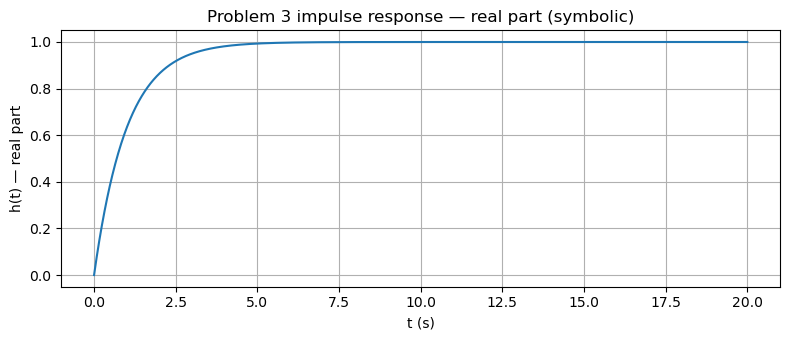

  Poles and multiplicities:
    -1    multiplicity = 2
    0    multiplicity = 1
  Stability verdict: Marginal (imag axis pole, multiplicity=1) — not BIBO stable

Compact summary:
  Problem 1: Stable (all Re<0)  Poles: [((-2+0j), 1), ((-1+0j), 1)]
  Problem 2: Unstable (imag axis pole with multiplicity >=2)  Poles: [(-2j, 2), (2j, 2)]
  Problem 3: Marginal (imag axis pole, multiplicity=1) — not BIBO stable  Poles: [((-1.0000000000000326+0j), 2), (0j, 1)]


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


import sympy as sp
s, t = sp.symbols('s t')

def group_roots(roots, tol=1e-8):
    roots = list(roots)
    used = [False]*len(roots)
    groups = []
    for i, r in enumerate(roots):
        if used[i]: continue
        used[i] = True
        mult = 1
        for j in range(i+1, len(roots)):
            if used[j]: continue
            if abs(roots[j] - r) < tol:
                used[j] = True
                mult += 1
        groups.append((r, mult))
    return groups

def tf_inverse_laplace_sympy(num_coeffs, den_coeffs):
    num_poly = sum(sp.Rational(str(coef)) * s**exp for coef, exp in zip(num_coeffs, range(len(num_coeffs)-1, -1, -1)))
    den_poly = sum(sp.Rational(str(coef)) * s**exp for coef, exp in zip(den_coeffs, range(len(den_coeffs)-1, -1, -1)))
    H = sp.simplify(num_poly/den_poly)
    h_t = sp.inverse_laplace_transform(H, s, t)
    # substitute Heaviside(t) with 1 for t>=0
    h_t_no_heaviside = h_t.xreplace({sp.Heaviside(t): sp.Integer(1)})
    # numeric roots using sp.nroots
    den_poly_eval = sp.Poly(den_poly, s)
    roots = sp.nroots(den_poly_eval.as_expr())
    roots = [complex(r.evalf()) for r in roots]
    groups = group_roots(roots)
    return sp.simplify(h_t_no_heaviside), groups

# Worksheet problems
worksheet = [
    ([1], [1, 3, 2], "H1(s) = 1 / (s^2 + 3s + 2)  -> poles at -1 and -2 (stable)"),
    ([1], [1, 0, 8, 0, 16], "H2(s) = 1 / (s^4 + 0*s^3 + 8*s^2 + 0*s + 16)  = 1/(s^2+4)^2  -> poles ±2j, multiplicity 2 (unstable)"),
    ([1, 1], [1, 2, 1, 0], "H3(s) = (s+1) / (s (s+1)^2)  -> poles at 0 (simple) and -1 (double) (marginal due to pole at 0)"),
]

t_vals = np.linspace(0, 20, 2001)

results = []
for i, (num, den, desc) in enumerate(worksheet, start=1):
    print(f"\nProblem {i}: {desc}")
    try:
        h_sym, groups = tf_inverse_laplace_sympy(num, den)
        print("  Symbolic inverse Laplace h(t):")
        sp.pprint(sp.simplify(h_sym), wrap_line=False)
        # Lambdify and plot (Heaviside removed)
        h_num = sp.lambdify(t, sp.simplify(h_sym), 'numpy')
        h_vals = h_num(t_vals)
        plt.figure(figsize=(8,3.5))
        plt.plot(t_vals, np.real(h_vals))
        plt.title(f"Problem {i} impulse response — real part (symbolic)")
        plt.xlabel("t (s)")
        plt.ylabel("h(t) — real part")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("  Symbolic inverse Laplace or plotting failed:", e)
        # Fallback: show poles via numpy.roots
        den_roots = np.roots(den)
        groups = group_roots(den_roots)
        print("  Poles (numpy.roots):", groups)
    # Print grouped poles and verdict
    print("  Poles and multiplicities:")
    for root, m in groups:
        rr = complex(root)
        print(f"    {rr.real:.6g}" + (f"+{rr.imag:.6g}j" if abs(rr.imag)>1e-12 else "") + f"    multiplicity = {m}")
    # Stability verdict
    verdict = "Stable"
    if any(r.real > 1e-12 for r,m in groups):
        verdict = "Unstable (RHP pole)"
    else:
        imag_axis = [(r,m) for r,m in groups if abs(r.real) <= 1e-12]
        if any(m >= 2 for r,m in imag_axis):
            verdict = "Unstable (imag axis pole with multiplicity >=2)"
        elif len(imag_axis) > 0:
            verdict = "Marginal (imag axis pole, multiplicity=1) — not BIBO stable"
        else:
            verdict = "Stable (all Re<0)"
    print("  Stability verdict:", verdict)
    results.append((num, den, groups, verdict))

print("\nCompact summary:")
for i, (num, den, groups, verdict) in enumerate(results, start=1):
    print(f"  Problem {i}: {verdict}  Poles: {[ (complex(r),m) for r,m in groups ]}")




## Applications of BIBO Stability & Transfer Functions Beyond Classical Control

Although BIBO stability and transfer-function analysis originated in electrical and mechanical control theory, these concepts apply to any system that processes signals, evolves over time, or forms feedback loops. Below are important cross-disciplinary applications.

1. Machine Learning / Deep Learning — Stability of RNNs

Recurrent neural networks behave like discrete-time dynamical systems:

        h(t+1) = f(Wh(t)+Ux(t))

The system remains stable only if the spectral radius of the recurrent matrix satisfies:
        
        p(W) < 1

Otherwise:

* activations diverge,
* gradients explode,
* training becomes impossible.

Modern architectures (LSTMs, GRUs) were designed specifically to stabilize these dynamics.


2. Quantitative Finance — Stability of Price Impact Models

Execution price models resemble linear systems:

        P(t+1) = p(t)+ kq(t)+ e(t)

If a trading algorithm reacts to prices in a reinforcing manner, the loop can become unstable, causing:

* liquidity crashes
* price oscillations
* runaway impact

Stability analysis ensures that a trading strategy does not blow up under feedback.


3. Algorithmic Trading — Feedback Stability of Market-Making Strategies

Market makers adjust quotes → which affect order flow → which again affects their quotes.
This forms a closed-loop system.

Stability guarantees:

* inventory remains bounded
* no oscillatory quoting
* controlled PnL variance

Unstable feedback can amplify noise and trigger rapid inventory divergence.


4. Machine Learning Optimization — Stability of Gradient Descent

Gradient descent is itself a dynamical system:

        x(k+1) = x(k) - a grad(f(x(k)))

For quadratic functions, the update behaves like a linear system.
The method is stable only if:

        0 < a < 2/L

Too large a step size → oscillation and divergence.



NOTE: I will be covering all those applications one by one in subsequent notebooks